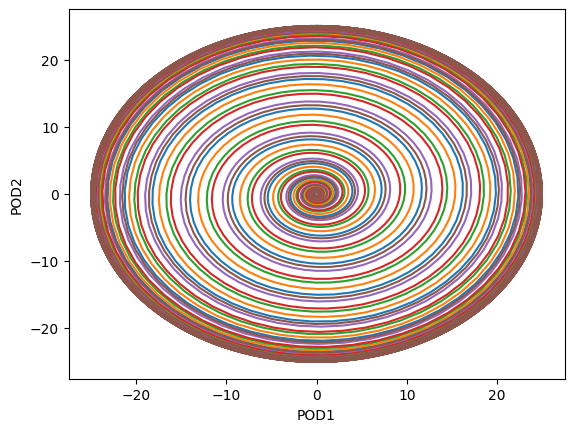

In [40]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
from ssmlearnpy.reduced_dynamics.advector import advect
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = loadmat('data.mat')
n_traj = len(mat['PODTraj'])
idx_train = [0, 2, 4, 5, 7, 8]
idx_test = [1, 3, 6]
n_traj_train, n_traj_test = len(idx_train), len(idx_test)

t_train = [mat['PODTraj'][i][0].flatten() for i in idx_train]
x_full_train = [mat['PODTraj'][i][1] for i in idx_train]
x_reduced_train = [mat['PODTraj'][i][1][:2,:] for i in idx_train]

n_traj_test = len(mat['PODTraj'])-n_traj_train
t_test = [mat['PODTraj'][i][0].flatten() for i in idx_test]
x_full_test = [mat['PODTraj'][i][1] for i in idx_test]
x_reduced_test = [mat['PODTraj'][i][1][:2,:] for i in idx_test]

for i_traj in range(n_traj_train):
    plt.plot(
        x_reduced_train[i_traj][0,:], 
        x_reduced_train[i_traj][1,:]
    )

plt.xlabel("POD1")
plt.ylabel("POD2")

plt.show() 

In [41]:
ssm = SSMLearn(
    t = t_train, 
    x = x_full_train, 
    reduced_coordinates = x_reduced_train,
    ssm_dim=2, 
    dynamics_type = 'flow'
)
ssm.get_parametrization(poly_degree=18)    
ssm.get_reduced_dynamics(poly_degree=11) 
ssm.predict()  

INFO   2022-10-05 11:25:14 ridge Transforming data
INFO   2022-10-05 11:25:14 ridge Skipping CV on ridge regression
INFO   2022-10-05 11:25:14 ridge Fitting regression model
INFO   2022-10-05 11:25:14 ridge Transforming data
INFO   2022-10-05 11:25:14 ridge Skipping CV on ridge regression
INFO   2022-10-05 11:25:14 ridge Fitting regression model


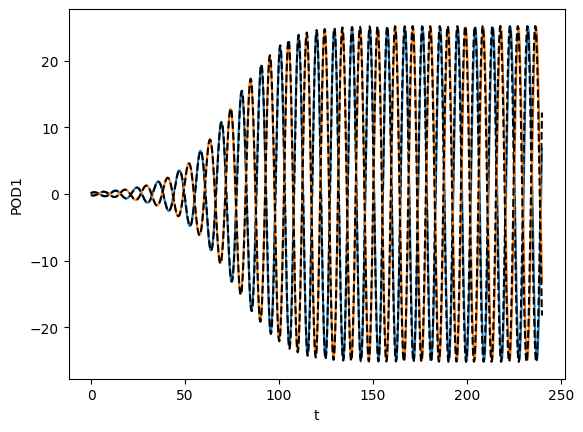

In [42]:
t_predict = ssm.reduced_dynamics_predictions['time']
x_predict = ssm.reduced_dynamics_predictions['reduced_coordinates']
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in (1,4):
    plt.plot(
        t_train[i_traj], 
        x_reduced_train[i_traj][0,:]
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'k--'
    )

plt.xlabel("t")
plt.ylabel("POD1")

plt.show()  

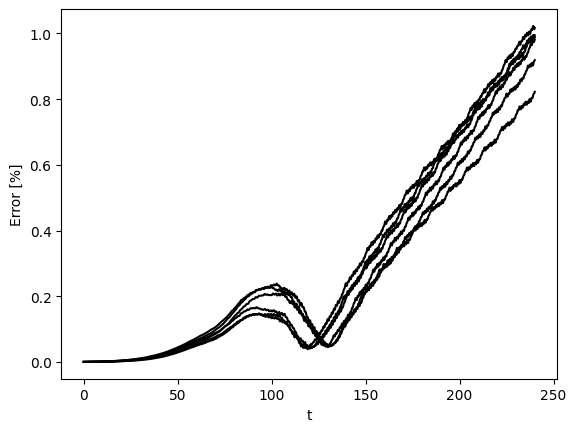

In [43]:
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")

plt.show()  

In [44]:
print(np.linspace(0, 25, 11))

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25. ]


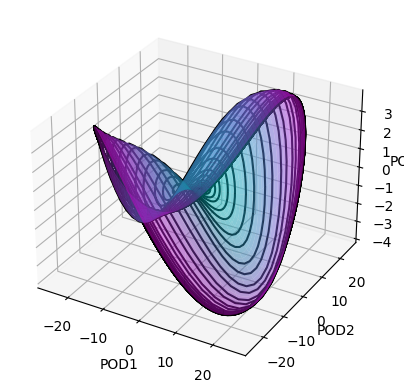

In [45]:
t_predict = ssm.predictions['time']
x_predict = ssm.predictions['observables']
e_predict = ssm.predictions['errors']


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

# Surface data
r_vec = np.linspace(0, 25, 101)
th_vec = np.linspace(0, 2*np.pi, 101)
r_mesh, th_mesh = np.meshgrid(r_vec,th_vec)
x_mesh, y_mesh = r_mesh*np.cos(th_mesh), r_mesh*np.sin(th_mesh)
x_reduced_surf = np.array([x_mesh.flatten(), y_mesh.flatten(),])

x_full_surf = ssm.decoder.predict(x_reduced_surf.T).T
n_coord = 3
z_vec = x_full_surf[n_coord,:]
z_mesh = z_vec.reshape(x_mesh.shape)
surf_coloring = r_mesh/np.amax(r_mesh)
my_col = cm.cool(np.square(surf_coloring))

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, facecolors=my_col,
                       linewidth=0, antialiased=True, alpha=0.5)

for i_traj in (1,4):
    ax.plot3D(
        x_reduced_train[i_traj][0,:], 
        x_reduced_train[i_traj][1,:], 
        x_full_train[i_traj][n_coord,:],
        'k'
    )

ax.set_xlabel("POD1")
ax.set_ylabel("POD2")
ax.set_zlabel("POD5")
ax.xaxis.labelpad=1
ax.yaxis.labelpad=1
ax.zaxis.labelpad=1
plt.show()

In [46]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_surface(
    x=x_mesh,
    y=y_mesh,
    z=z_mesh,
    surfacecolor=np.square(surf_coloring),
    opacity = 0.7,
    colorscale='agsunset',
    showscale=False,
    showlegend=False
)
line_marker = dict(color='#101010', width=2)
for i_traj in (1,4):
    fig.add_scatter3d(
        x=x_reduced_train[i_traj][0,:], 
        y=x_reduced_train[i_traj][1,:], 
        z=x_full_train[i_traj][n_coord,:],
        mode='lines', 
        line=line_marker, 
        name='',
        showlegend=False
    )
plt_width = 560  
plt_height = 420
plt_margins = plt_width / 20
fig.update_layout(title='SSM', autosize=True,
                  width=plt_width, height=plt_height,
                  margin=dict(l=plt_margins, r=plt_margins, b=plt_margins, t=plt_margins), 
                  scene = dict(
                    xaxis_title='POD<sub>1</sub>',
                    yaxis_title='POD<sub>2</sub>',
                    zaxis_title='POD<sub>3</sub>'),
                  font_family='Helvetica',
                  font_color='black'
)
fig.show()


In [47]:
test_predictions = ssm.predict(t = t_test, x = x_full_test, x_reduced = x_reduced_test)  

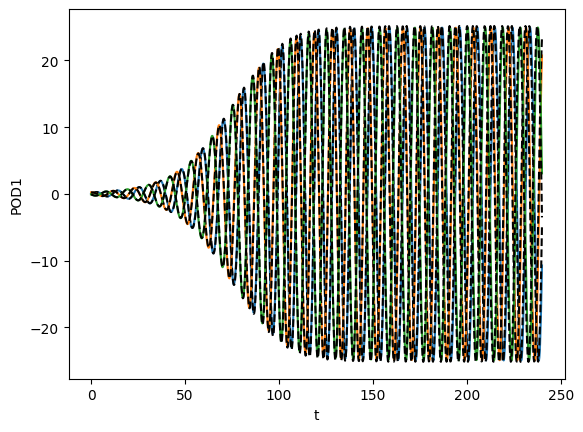

In [48]:
t_predict = test_predictions['time']
x_predict = test_predictions['reduced_coordinates']
e_predict = test_predictions['errors']
for i_traj in range(n_traj_test):
    plt.plot(
        t_test[i_traj], 
        x_reduced_test[i_traj][0,:]
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'k--'
    )

plt.xlabel("t")
plt.ylabel("POD1")

plt.show()  

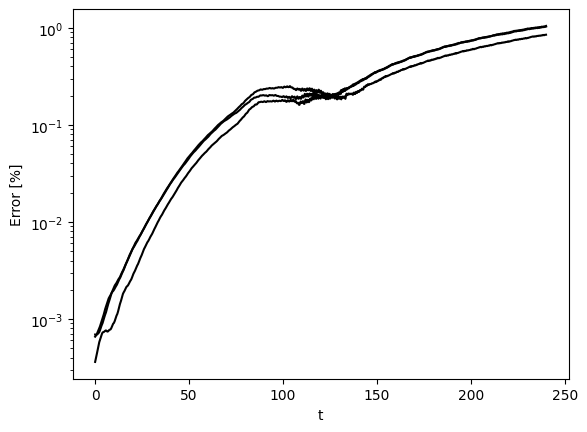

In [49]:
for i_traj in range(n_traj_test):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")
plt.yscale("log")
plt.show()  